# DECEPTIVE REVIEW CLASSIFIER

In [346]:
!pip install transformers==2.5.0

In [347]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [348]:
#learning word embeddings on training data using Gensim library
from gensim.models import Word2Vec, KeyedVectors
# gensim modules
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec

In [349]:
#importing libraries
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import statistics
import math
import os
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import re
pd.set_option('max_colwidth', 800)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [350]:
#loading dataset
df=pd.read_csv('/content/deceptive.csv')
df.head()

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n"
1,truthful,hyatt,positive,TripAdvisor,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n"
2,truthful,hyatt,positive,TripAdvisor,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h..."
3,truthful,omni,positive,TripAdvisor,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n"
4,truthful,hyatt,positive,TripAdvisor,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were pleasant and prompt. I used the fitness center which was well equipped and everything was in working order. It is in a great location at one end of the Michigan Avenue shopping district. \n"


In [351]:
df.shape

(1600, 5)

In [352]:
df['deceptive'].value_counts()

truthful     800
deceptive    800
Name: deceptive, dtype: int64

In [353]:
df['polarity'].value_counts()

negative    800
positive    800
Name: polarity, dtype: int64

This is perfectly balanced dataset. Our target variable is 'deceptive'.

In [354]:
df['hotel'].value_counts()

intercontinental    80
conrad              80
james               80
affinia             80
hilton              80
amalfi              80
palmer              80
sheraton            80
monaco              80
allegro             80
talbott             80
omni                80
ambassador          80
hyatt               80
homewood            80
swissotel           80
fairmont            80
sofitel             80
hardrock            80
knickerbocker       80
Name: hotel, dtype: int64

In [355]:
df['source'].value_counts()

MTurk          800
Web            400
TripAdvisor    400
Name: source, dtype: int64

### DATA PREPROCESSING AND EDA

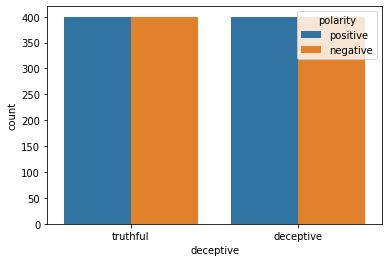

In [356]:
import seaborn as sns
sns.countplot(x=df['deceptive'],hue='polarity',data=df)

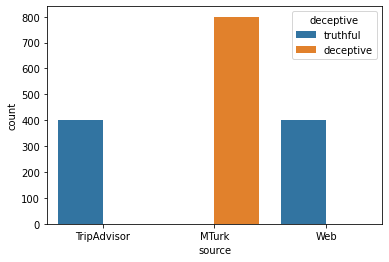

In [357]:
sns.countplot(x=df['source'],hue='deceptive',data=df)

In [358]:
df.columns

Index(['deceptive', 'hotel', 'polarity', 'source', 'text'], dtype='object')

In [359]:
# so combining three text columns --- hotel, source, text
#df['text'] = df['hotel']+' '+df['source']+' '+df['text']
#df.head()

In [360]:
# dropping unnecessary columns. 
# dropping hotel names
# dropping the source of the data
# dropping the polarity of the dataset
df.drop(['hotel', 'polarity', 'source'], axis = 1, inplace=True)
df.head()

,deceptive,text
0,truthful,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n"
1,truthful,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n"
2,truthful,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h..."
3,truthful,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n"
4,truthful,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were pleasant and prompt. I used the fitness center which was well equipped and everything was in working order. It is in a great location at one end of the Michigan Avenue shopping district. \n"


In [361]:
z = {'truthful' : 1, 'deceptive' : 0}  # 1 for truthful reviews and 0 for deceptive reviews
df['deceptive'] = df['deceptive'].map(z)

In [362]:
df.head()

,deceptive,text
0,1,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n"
1,1,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n"
2,1,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h..."
3,1,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n"
4,1,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were pleasant and prompt. I used the fitness center which was well equipped and everything was in working order. It is in a great location at one end of the Michigan Avenue shopping district. \n"


In [363]:
# Cleaning Raw tweets
def clean_text(text):
    
    #remove emails
    text = ' '.join([i for i in text.split() if '@' not in i])
    
    #remove web address
    text = re.sub('http[s]?://\S+', '', text)

    #remove brackets and parantheses (and removing the text inside the brackets and parantheses)
    text = re.sub("[\(\[].*?[\)\]]", "", text)

    #remove punctuations
    text = re.sub(r'[^\w\s]', ' ', text)
    
    #Filter to allow only alphabets and numbers
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    
    #Remove Unicode characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    #remove double spaces 
    text = re.sub('\s+', ' ', text)
    
    return text

In [364]:
# applying that into function.
df["clean_text"] = df['text'].apply(lambda x: clean_text(x))
df.head(10)

,deceptive,text,clean_text
0,1,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n",We stayed for a one night getaway with family on a thursday Triple AAA rate of was a steal th floor room complete with in plasma TV bose stereo voss and evian water and gorgeous bathroom Concierge was very helpful You cannot beat this location Only flaw was breakfast was pricey and service was very very slow even though there were only two other tables in the restaurant Food was very good so it was worth the wait I would return in a heartbeat A gem in chicago
1,1,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n",Triple A rate with upgrade to view room was less than which also included breakfast vouchers Had a great view of river lake Wrigley Bldg Tribune Bldg Most major restaurants Shopping Sightseeing attractions within walking distance Large room with a very comfortable bed
2,1,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h...",This comes a little late as I m finally catching up on my reviews from the past several months A dear friend and I stayed at the Hyatt Regency in late October for one night while visiting a friend and her husband from out of town This hotel is perfect IMO Easy check in and check out Lovely clean comfortable rooms with great views of the city I know this area pretty well and it s very convenient to many downtown Chicago attractions We had dinner and went clubing with our friends around Division St We had no problems getting cabs back and forth to the Hyatt and there s even public transportation right near by but we didn t bother since we only needed cabs from and to the hotel Parking as is usual for Chicago was expensive but we were able to get our car out quickly No problems at all and...
3,1,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n",The Omni Chicago really delivers on all front

In [365]:
# dropping the uncleaned text column "text"
df = df.drop(['text'], axis=1)

In [366]:
# renaming the column
df.rename(columns = {'clean_text':'text', 'deceptive' : 'label'}, inplace = True)
df.head()

,label,text
0,1,We stayed for a one night getaway with family on a thursday Triple AAA rate of was a steal th floor room complete with in plasma TV bose stereo voss and evian water and gorgeous bathroom Concierge was very helpful You cannot beat this location Only flaw was breakfast was pricey and service was very very slow even though there were only two other tables in the restaurant Food was very good so it was worth the wait I would return in a heartbeat A gem in chicago
1,1,Triple A rate with upgrade to view room was less than which also included breakfast vouchers Had a great view of river lake Wrigley Bldg Tribune Bldg Most major restaurants Shopping Sightseeing attractions within walking distance Large room with a very comfortable bed
2,1,This comes a little late as I m finally catching up on my reviews from the past several months A dear friend and I stayed at the Hyatt Regency in late October for one night while visiting a friend and her husband from out of town This hotel is perfect IMO Easy check in and check out Lovely clean comfortable rooms with great views of the city I know this area pretty well and it s very convenient to many downtown Chicago attractions We had dinner and went clubing with our friends around Division St We had no problems getting cabs back and forth to the Hyatt and there s even public transportation right near by but we didn t bother since we only needed cabs from and to the hotel Parking as is usual for Chicago was expensive but we were able to get our car out quickly No problems at all and...
3,1,The Omni Chicago really delivers on all fronts from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue While this address in Chicago requires a high level of quality the Omni delivers Check in for myself and a whole group of people with me was under minutes the staff had plentiful recommendations for dining and events and the rooms are some of the largest you ll find at this price range in Chicago Even the standard room has a separate living area and work desk The fitness center has free weights weight machines and two rows of cardio equipment I shared the room with others and did not feel cramped in any way All in all a great property
4,1,I asked for a high floor away from the elevator and that is what I got The room was pleasantly decorated functional and very clean I didn t need a whole lot of service but when I did they were pleasant and prompt I used the fitness center which was well equipped and everything was in working order It is in a great location at one end of the Michigan Avenue shopping district


In [367]:
# preprocessing the data (removing stopwords, convert the sentence to lower case, and also applying lemmatization to get meaningful words )
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
wnl=WordNetLemmatizer()
corpus=[]
def clean_text(review):
  review = review.lower()
  review = review.split()
  review = [wnl.lemmatize(word) for word in review if word not in set(stopwords.words('english'))]
  review = ' '.join(review)
  return review

In [368]:
df['text']=df['text'].apply(clean_text)
df.head()

,label,text
0,1,stayed one night getaway family thursday triple aaa rate steal th floor room complete plasma tv bose stereo voss evian water gorgeous bathroom concierge helpful cannot beat location flaw breakfast pricey service slow even though two table restaurant food good worth wait would return heartbeat gem chicago
1,1,triple rate upgrade view room le also included breakfast voucher great view river lake wrigley bldg tribune bldg major restaurant shopping sightseeing attraction within walking distance large room comfortable bed
2,1,come little late finally catching review past several month dear friend stayed hyatt regency late october one night visiting friend husband town hotel perfect imo easy check check lovely clean comfortable room great view city know area pretty well convenient many downtown chicago attraction dinner went clubing friend around division st problem getting cab back forth hyatt even public transportation right near bother since needed cab hotel parking usual chicago expensive able get car quickly problem best part got rate hotwire downright steal area chicago quality hotel
3,1,omni chicago really delivers front spaciousness room helpful staff prized location michigan avenue address chicago requires high level quality omni delivers check whole group people minute staff plentiful recommendation dining event room largest find price range chicago even standard room separate living area work desk fitness center free weight weight machine two row cardio equipment shared room others feel cramped way great property
4,1,asked high floor away elevator got room pleasantly decorated functional clean need whole lot service pleasant prompt used fitness center well equipped everything working order great location one end michigan avenue shopping district


### WORD VISUALIZATION

In [369]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [370]:
#making worldcloud
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))
print(stop_words)

{'from', 'that', 'some', 'ma', 't', "don't", 'after', 'shouldn', 'so', "mightn't", 'm', 'these', 'own', 'aren', 'most', 'your', 'the', 'isn', 'both', 'at', 'don', 'shan', 'being', "hadn't", 'until', "you'd", 'this', 'should', 'ain', 'him', "needn't", 'can', 'an', 'here', "couldn't", 'mightn', "should've", 'needn', 'but', 'how', 'weren', 'with', 'where', 'haven', 'down', 'has', "aren't", 'did', 'won', 'she', 'does', 'me', 'other', 'mustn', 'more', 'a', 'just', 'in', "doesn't", 'when', 'they', "mustn't", 'is', 'ourselves', 'now', 'yourselves', 'y', 'doing', 'of', 'their', 'which', 'against', 'yourself', 'her', 'no', 'd', 'itself', 'out', 'each', 'do', 'was', 're', 'hadn', 'such', 'were', 'then', 'hers', "it's", 'it', 've', 'what', "weren't", 'whom', 'yours', 'why', 'i', 'himself', 'and', 'there', 'any', 'been', 'few', 'be', 'once', 'those', 'couldn', 'he', "she's", 'am', 'by', 'ours', 'having', 'or', "wouldn't", 'who', 'wasn', 'while', 'over', 'through', 'hasn', "haven't", 'on', 'you', '

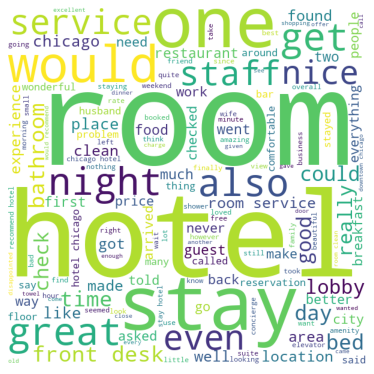

In [371]:
# visualizing the most frequent words using matplot library
comment_words = ' '
for words in df['text']: 
    comment_words = comment_words + words + ' '
    
wordcloud = WordCloud(width = 600, height = 600, 
                background_color='white' , 
                stopwords = stop_words, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

### FEATURE EXTRACTION USING TF-IDF VECTORIZER

In [372]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
import gensim

In [373]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=3000, ngram_range=(1,3), stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df['text'])
tfidf.shape

(1600, 3000)

### FEATURE EXTRACTION USING WORD2VEC

In [374]:
y= df['label']

In [375]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
tokenizer

RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)

In [376]:
tokenized_tweet = df['text'].apply(lambda x: x.split()) # tokenizing 
tokenized_tweet

0                                                                                                                                                                                                                                                                                                                                                                                                                                                               [stayed, one, night, getaway, family, thursday, triple, aaa, rate, steal, th, floor, room, complete, plasma, tv, bose, stereo, voss, evian, water, gorgeous, bathroom, concierge, helpful, cannot, beat, location, flaw, breakfast, pricey, service, slow, even, though, two, table, restaurant, food, good, worth, wait, would, return, heartbeat, gem, chicago]
1                                                                                                                                                                                                     

In [377]:
import gensim

In [378]:
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=3, # Ignores all words with total frequency lower than 2.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 32, # no.of cores
            seed = 34
)

In [379]:
model_w2v.train(tokenized_tweet, total_examples= len(df['text']), epochs=20)

(1884141, 2269440)

In [380]:
model_w2v.wv.most_similar(positive="room")

[('wonderfully', 0.5485422611236572),
 ('suited', 0.5463186502456665),
 ('partial', 0.5430978536605835),
 ('spotlessly', 0.540601372718811),
 ('rested', 0.5371255278587341),
 ('soothing', 0.5338535904884338),
 ('cot', 0.5326371192932129),
 ('sterile', 0.5308870673179626),
 ('redone', 0.5275386571884155),
 ('sits', 0.5231911540031433)]

In [381]:
model_w2v['hotel']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-0.21454911,  0.04836474, -0.15786552, -0.30548552, -0.18292688,
        0.07591403,  0.04653281,  0.2728852 , -0.09105045, -0.13697557,
        0.02855591,  0.22002365,  0.18431988,  0.12755717, -0.10885011,
       -0.05306207,  0.17947532,  0.07241791,  0.04651321, -0.16527446,
       -0.10404295,  0.18531132,  0.2083694 ,  0.05654248,  0.15032248,
        0.24084663,  0.13384429,  0.17329742,  0.04245631, -0.11517716,
       -0.06167611,  0.04870661, -0.02312933,  0.05968051,  0.09941373,
        0.15338835, -0.00077965, -0.16606581,  0.10678963, -0.30075094,
        0.37643823, -0.0397913 ,  0.03284304,  0.15086862, -0.10252205,
        0.3734427 , -0.27888924,  0.06988347, -0.16214928,  0.02351351,
        0.0384809 , -0.13519807, -0.29975873,  0.01954816,  0.01730939,
       -0.06766509,  0.18159805, -0.03901619,  0.2126128 ,  0.15351431,
       -0.26332346, -0.04324862, -0.00623772, -0.06385279,  0.07226125,
        0.25862965, -0.05624213,  0.04630119, -0.0900876 ,  0.16

In [382]:
len(model_w2v['hotel']) 
#The length of the vector is 100

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


200

In [383]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [384]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200)) 
for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(1600, 200)

In [385]:
wordvec_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,-0.098775,0.160670,-0.027588,-0.049272,0.007778,-0.056314,0.092797,0.052445,0.181595,-0.122526,0.058841,0.059817,-0.095840,-0.009301,0.043256,-0.111565,-0.059233,-0.013347,0.118641,-0.144146,-0.146365,0.079916,0.099442,0.045268,-0.049920,0.119860,-0.008276,-0.086009,0.065918,-0.114779,-0.156368,0.066811,0.235861,0.002904,0.019167,0.101866,0.058548,-0.123960,-0.131483,-0.197898,...,-0.167144,-0.006283,-0.043641,0.274732,-0.148182,-0.000386,0.006067,-0.001211,-0.078200,0.242945,0.230419,0.039529,0.274109,-0.046473,-0.070220,0.067931,-0.000107,-0.083791,-0.050253,-0.149203,0.152240,-0.289848,-0.151273,-0.171892,0.077052,-0.076483,0.064939,-0.224054,-0.005325,-0.091473,-0.163237,0.008375,-0.000157,-0.144993,0.236241,0.012842,0.183077,-0.067961,-0.056366,-0.146491
1,-0.205915,0.097371,-0.086801,0.080995,0.028745,-0.159325,0.073734,0.043222,0.039666,-0.123486,0.125443,-0.033151,-0.153735,0.022640,-0.000514,-0.217274,-0.043839,0.042576,0.182730,-0.060874,-0.160785,-0.010145,0.094871,0.101006,0.019594,0.000040,0.054771,-0.086888,-0.045020,-0.169498,-0.128269,0.021372,0.290149,0.017036,-0.159145,0.118678,0.156553,-0.097038,-0.185989,-0.243585,...,-0.181015,-0.069351,-0.054738,0.176407,-0.185881,-0.121563,-0.015646,-0.103561,0.021986,0.250727,0.254482,-0.059285,0.270767,-0.070277,-0.137633,0.100722,-0.075116,-0.017671,-0.092201,-0.160223,0.224575,-0.334510,-0.263836,-0.194923,-0.009823,-0.188365,0.015837,-0.232102,-0.029716,-0.123716,-0.118904,0.013130,-0.092502,-0.359892,0.143409,-0.058795,0.207010,-0.068490,-0.158538,-0.220946
2,-0.120882,0.093822,-0.019855,-0.018428,0.029951,-0.023627,0.034638,0.077212,0.126618,-0.107611,-0.023790,0.070976,-0.051983,-0.017535,-0.041887,-0.084833,0.000649,-0.056347,0.176909,-0.076853,-0.170307,0.122374,0.173838,0.091138,0.003490,0.073808,0.120490,0.042678,-0.002210,-0.100215,-0.152090,0.023809,0.161630,0.085853,-0.085356,0.136012,0.183889,-0.143409,-0.091604,-0.342906,...,-0.163193,-0.008784,-0.037781,0.197963,-0.165164,-0.008723,0.083792,-0.075404,-0.059471,0.268825,0.250684,0.081787,0.162413,-0.095694,-0.103911,0.140913,-0.100421,-0.124496,0.023471,-0.120446,0.173557,-0.244590,-0.140147,-0.165348,0.109239,-0.041096,-0.001513,-0.192507,0.015055,-0.070272,-0.190247,0.004243,-0.108509,-0.092702,0.060090,0.042901,0.193230,0.009840,-0.114562,-0.103182
3,-0.128958,0.164102,-0.043766,0.000047,0.043643,-0.033885,0.100034,0.015187,0.139802,-0.100560,-0.004031,-0.002872,-0.102705,-0.029568,-0.045170,-0.126602,-0.060176,-0.008204,0.096388,-0.122709,-0.175118,0.079451,0.074103,0.109174,0.002116,0.061990,0.063782,-0.067618,0.101653,-0.047507,-0.180573,0.052154,0.156002,0.071467,-0.000378,0.126224,0.103266,-0.069340,-0.115600,-0.302869,...,-0.111701,-0.016943,-0.021965,0.192884,-0.144149,-0.029048,0.003978,-0.001275,-0.003874,0.243129,0.206465,0.047371,0.200340,-0.099794,-0.071969,0.066960,-0.131427,-0.073236,0.012778,-0.108648,0.133238,-0.217284,-0.105446,-0.209503,0.116401,-0.080698,0.005717,-0.235781,0.006554,-0.080607,-0.132210,-0.030489,0.021236,-0.108358,0.143128,0.050791,0.173977,-0.101969,-0.126701,-0.121131
4,-0.148320,0.141945,-0.025045,0.027570,0.063261,-0.092612,0.032338,0.107649,0.136002,-0.097177,0.064171,0.097780,-0.116755,-0.076376,0.097472,-0.082238,-0.126663,-0.075025,0.107237,-0.060408,-0.198067,0.109247,0.059741,0.057104,-0.043751,0.069158,0.085709,0.013089,0.044936,-0.092339,-0.278335,0.076597,0.236636,0.000373,-0.070918,0.164671,0.176897,-0.103732,-0.039523,-0.301223,...,-0.179888,0.042606,0.001828,0.166094,-0.096418,-0.054485,0.013143,-0.072452,0.020172,0.159600,0.200308,0.078243,0.241008,-0.035159,-0.071975,0.109264,-0.206644,-0.045530,-0.032704,-0.094375,0.109890,-0.251633,-0.195446,-0.195290,0.114880,-0.196555,-0.05

### FEATURE EXTRACTION USING DOC2VEC

In [386]:
from tqdm import tqdm 
tqdm.pandas(desc="progress-bar") 
from gensim.models.doc2vec import LabeledSentence

In [387]:
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output

labeled_tweets = add_label(tokenized_tweet) # label all the tweets

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  after removing the cwd from sys.path.


In [388]:
labeled_tweets[:4]

[LabeledSentence(words=['stayed', 'one', 'night', 'getaway', 'family', 'thursday', 'triple', 'aaa', 'rate', 'steal', 'th', 'floor', 'room', 'complete', 'plasma', 'tv', 'bose', 'stereo', 'voss', 'evian', 'water', 'gorgeous', 'bathroom', 'concierge', 'helpful', 'cannot', 'beat', 'location', 'flaw', 'breakfast', 'pricey', 'service', 'slow', 'even', 'though', 'two', 'table', 'restaurant', 'food', 'good', 'worth', 'wait', 'would', 'return', 'heartbeat', 'gem', 'chicago'], tags=['tweet_0']),
 LabeledSentence(words=['triple', 'rate', 'upgrade', 'view', 'room', 'le', 'also', 'included', 'breakfast', 'voucher', 'great', 'view', 'river', 'lake', 'wrigley', 'bldg', 'tribune', 'bldg', 'major', 'restaurant', 'shopping', 'sightseeing', 'attraction', 'within', 'walking', 'distance', 'large', 'room', 'comfortable', 'bed'], tags=['tweet_1']),
 LabeledSentence(words=['come', 'little', 'late', 'finally', 'catching', 'review', 'past', 'several', 'month', 'dear', 'friend', 'stayed', 'hyatt', 'regency', 'la

In [389]:
%%time 
model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model
                                  dm_mean=1, # dm_mean = 1 for using mean of the context word vectors
                                  vector_size=200, # no. of desired features
                                  window=5, # width of the context window                                  
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=5, # Ignores all words with total frequency lower than 5.                                  
                                  workers=32, # no. of cores                                  
                                  alpha=0.1, # learning rate                                  
                                  seed = 23, # for reproducibility
                                 ) 

model_d2v.build_vocab([i for i in tqdm(labeled_tweets)])

model_d2v.train(labeled_tweets, total_examples= len(df['text']), epochs=15)

100%|██████████| 1600/1600 [00:00<00:00, 810199.98it/s]


CPU times: user 10.3 s, sys: 1.02 s, total: 11.3 s
Wall time: 7.48 s


In [390]:
docvec_arrays = np.zeros((len(tokenized_tweet), 200)) 
for i in range(len(tokenized_tweet)):
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,200))    

docvec_df = pd.DataFrame(docvec_arrays) 
docvec_df.shape

(1600, 200)

In [391]:
docvec_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,-0.346927,0.036473,0.184363,0.326397,-0.053586,0.181988,-0.445449,0.322990,0.530889,-0.082966,0.548662,-0.330891,0.001461,-0.124871,0.159176,-0.227282,0.071479,0.527399,0.063648,-0.153122,-0.205726,-0.034227,0.419937,-0.074191,-0.118013,-0.592384,0.189006,0.275093,0.323100,-0.263790,-0.177927,0.170936,0.331972,-0.336828,0.338347,-0.299776,0.585610,0.706437,-0.012733,-0.401483,...,-0.187319,-0.414177,-0.180912,0.406856,0.453460,-0.168772,0.196405,0.828325,0.400261,-0.584158,-0.277121,-0.500930,0.768299,-0.243057,-0.209405,-0.299148,0.341154,0.355069,-0.184914,0.675723,0.170674,-0.279304,-0.082593,-0.149291,0.177768,0.819135,-0.301608,0.255026,0.424798,0.145057,-0.164312,0.314373,0.012379,0.021522,0.433716,-0.511619,-0.129431,-0.093506,-0.243418,0.357844
1,-0.011463,-0.275910,0.025871,-0.283490,0.210246,0.125342,-0.303807,0.311988,0.322584,-0.371593,0.531414,-0.029624,0.030936,-0.191085,0.112029,-0.174089,-0.055330,0.210052,0.048846,-0.240814,-0.036288,-0.142461,0.308963,0.151045,-0.078323,-0.256487,0.514690,0.093361,0.203210,0.041938,-0.391383,0.196975,0.556607,0.207312,0.100449,-0.092805,0.399218,0.110207,0.100073,-0.139970,...,0.008551,-0.444377,0.112544,0.096951,0.089749,-0.108836,-0.289645,0.694611,0.052199,-0.146690,0.329102,-0.012694,0.525714,-0.236521,-0.188901,0.046449,-0.058935,0.382759,-0.447201,0.601005,-0.423231,0.124740,0.075111,-0.232471,0.204183,0.296279,-0.387358,0.015724,0.239824,-0.002663,-0.092590,0.254663,0.081632,-0.048027,-0.163587,-0.416833,-0.220689,0.172481,-0.181917,0.287694
2,-0.305075,-1.201396,0.022667,-0.280987,-0.888365,0.531579,-0.465662,0.062636,0.106157,-0.673069,0.415147,0.362028,0.618045,0.013047,0.075725,-0.025004,0.059204,-0.568791,-0.224983,-0.604425,-0.496915,0.328565,-0.373402,0.248068,-0.748113,0.518910,1.212072,0.825754,0.169050,0.289523,0.008348,0.318899,0.416971,0.319945,-0.008529,0.057202,-0.087627,0.469954,-0.341763,-0.456786,...,-0.024451,-0.533946,-0.178120,-0.733674,0.531948,-0.216748,-0.222382,-0.139394,0.184069,0.075442,0.593933,-0.279524,0.532821,-0.729081,-0.143143,0.432788,0.621710,-0.190957,-0.158445,0.179563,-0.046039,0.489291,0.552155,0.023599,-1.394108,0.110032,0.599739,0.643122,0.242941,-0.582136,0.190998,0.890642,-0.146095,-0.252544,-0.491386,0.175765,0.151077,0.804410,-0.975702,-0.526974
3,0.270371,-0.041357,0.266233,-0.358757,-0.160398,-0.289799,-0.506390,-0.167181,0.020539,0.114280,0.112404,-0.552947,0.373791,0.312837,-0.144968,-0.004533,-0.161609,-0.143663,0.358256,0.177767,-0.392042,0.356453,0.032461,0.027718,0.125047,-0.257353,0.319914,0.422495,-0.345747,0.188325,-0.354826,0.044340,0.155196,-0.111611,-0.059887,0.299058,0.078662,0.160359,-0.332294,-0.260820,...,0.265561,0.388842,0.227193,0.517344,-0.118025,0.119344,-0.028949,0.828277,-0.048896,-0.617160,0.340690,-0.330096,0.153530,-0.178348,-0.369152,0.216962,0.357058,0.282205,-0.012488,0.010097,-0.746013,0.024223,0.396373,-0.106326,-0.080538,-0.037415,0.642087,0.825502,0.134298,-0.392874,0.084313,-0.368627,-0.527230,-0.053062,-0.196765,-0.238954,-0.772689,0.496603,0.239465,0.410861
4,-0.661322,0.150384,0.365792,-0.421812,-0.073363,0.692409,-0.276546,-0.584231,0.651742,0.098275,1.218678,-0.227784,0.327722,0.073255,0.422763,-0.099295,0.130857,-0.232485,0.232169,0.136426,0.114392,0.052442,0.197712,0.154827,-0.086540,0.346803,0.242777,-0.082125,-0.261445,0.088734,-0.387807,0.495010,0.382039,0.160383,0.052066,0.052139,0.171273,0.135356,-0.039751,-0.129136,...,-0.079197,-0.399922,-0.162569,0.384930,0.369570,-0.350108,0.007712,0.099629,0.466947,-0.458248,0.078793,-0.342719,0.400679,-0.200526,0.049179,0.373425,-0.073395,0.181746,-0.056409,0.676399,-0.187807,0.180891,0.267872,0.200083,-0.265842,-0.020940,0.459814,0.269712,-0.131554,-0.158717,-0.0428

In [392]:
tfidf

<1600x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 89376 stored elements in Compressed Sparse Row format>

### MODEL BUILDING

#### LOGISTIC REGRESSION 

TFIDF

In [393]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(tfidf, y, test_size=0.1, random_state=1234)

In [394]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=10000) 
lr.fit(x_train,y_train)
y_pred=lr.predict(x_test)

In [395]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('accuracy_score: ', accuracy_score(y_test, y_pred))

[[77 10]
 [ 7 66]]
              precision    recall  f1-score   support

           0       0.92      0.89      0.90        87
           1       0.87      0.90      0.89        73

    accuracy                           0.89       160
   macro avg       0.89      0.89      0.89       160
weighted avg       0.89      0.89      0.89       160

accuracy_score:  0.89375


WORD2VEC

In [396]:
train_w2v = wordvec_df

# splitting data into training and validation set 
x_train, x_test, y_train, y_test = train_test_split(wordvec_df, y, random_state=1212, test_size=0.1)

lr = LogisticRegression(max_iter=10000) 
lr.fit(x_train,y_train)
y_pred=lr.predict(x_test)

In [397]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('accuracy_score: ', accuracy_score(y_test, y_pred))

[[66 12]
 [17 65]]
              precision    recall  f1-score   support

           0       0.80      0.85      0.82        78
           1       0.84      0.79      0.82        82

    accuracy                           0.82       160
   macro avg       0.82      0.82      0.82       160
weighted avg       0.82      0.82      0.82       160

accuracy_score:  0.81875


DOC2VEC

In [398]:
# splitting data into training and validation set 
x_train, x_test, y_train, y_test = train_test_split(docvec_df, y, random_state=1212, test_size=0.1)
lr = LogisticRegression(max_iter=10000) 
lr.fit(x_train,y_train)
y_pred=lr.predict(x_test)

In [399]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('accuracy_score: ', accuracy_score(y_test, y_pred))

[[58 20]
 [15 67]]
              precision    recall  f1-score   support

           0       0.79      0.74      0.77        78
           1       0.77      0.82      0.79        82

    accuracy                           0.78       160
   macro avg       0.78      0.78      0.78       160
weighted avg       0.78      0.78      0.78       160

accuracy_score:  0.78125


#### SUPPORT VECTOR MACHINE (SVM)

TFIDF

In [400]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(tfidf, y, test_size=0.1, random_state=1234)
from sklearn.svm import SVC
model1 = SVC()
model1.fit(x_train1,y_train1)
y_pred=model1.predict(x_test1)

In [401]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(confusion_matrix(y_test1, y_pred))
print(classification_report(y_test1, y_pred))
print('accuracy_score: ', accuracy_score(y_test1, y_pred))

[[77 10]
 [ 6 67]]
              precision    recall  f1-score   support

           0       0.93      0.89      0.91        87
           1       0.87      0.92      0.89        73

    accuracy                           0.90       160
   macro avg       0.90      0.90      0.90       160
weighted avg       0.90      0.90      0.90       160

accuracy_score:  0.9


WORD2VEC

In [402]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(wordvec_df, y, test_size=0.1, random_state=1234)
from sklearn.svm import SVC
model1 = SVC(C=1)
model1.fit(x_train1,y_train1)
y_pred=model1.predict(x_test1)

In [403]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(confusion_matrix(y_test1, y_pred))
print(classification_report(y_test1, y_pred))
print('accuracy_score: ', accuracy_score(y_test1, y_pred))

[[72 15]
 [ 9 64]]
              precision    recall  f1-score   support

           0       0.89      0.83      0.86        87
           1       0.81      0.88      0.84        73

    accuracy                           0.85       160
   macro avg       0.85      0.85      0.85       160
weighted avg       0.85      0.85      0.85       160

accuracy_score:  0.85


DOC2VEC

In [404]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(docvec_df, y, test_size=0.1, random_state=1234)
from sklearn.svm import SVC
model1 = SVC(C=6)
model1.fit(x_train1,y_train1)
y_pred=model1.predict(x_test1)

In [405]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(confusion_matrix(y_test1, y_pred))
print(classification_report(y_test1, y_pred))
print('accuracy_score: ', accuracy_score(y_test1, y_pred))

[[69 18]
 [10 63]]
              precision    recall  f1-score   support

           0       0.87      0.79      0.83        87
           1       0.78      0.86      0.82        73

    accuracy                           0.82       160
   macro avg       0.83      0.83      0.82       160
weighted avg       0.83      0.82      0.83       160

accuracy_score:  0.825


#### LINEAR SUPPORT VECTOR MACHINE (LSVM)

TFIDF

In [406]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(tfidf, y, test_size=0.1, random_state=1234)
from sklearn.svm import LinearSVC
models = LinearSVC()
models.fit(x_train1,y_train1)
y_pred=models.predict(x_test1)

In [407]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(confusion_matrix(y_test1, y_pred))
print(classification_report(y_test1, y_pred))
print('accuracy_score: ', accuracy_score(y_test1, y_pred))

[[78  9]
 [ 7 66]]
              precision    recall  f1-score   support

           0       0.92      0.90      0.91        87
           1       0.88      0.90      0.89        73

    accuracy                           0.90       160
   macro avg       0.90      0.90      0.90       160
weighted avg       0.90      0.90      0.90       160

accuracy_score:  0.9


WORD2VEC

In [408]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(wordvec_df, y, test_size=0.1, random_state=1234)
from sklearn.svm import LinearSVC
model1 = LinearSVC()
model1.fit(x_train1,y_train1)
y_pred=model1.predict(x_test1)

In [409]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(confusion_matrix(y_test1, y_pred))
print(classification_report(y_test1, y_pred))
print('accuracy_score: ', accuracy_score(y_test1, y_pred))

[[73 14]
 [ 8 65]]
              precision    recall  f1-score   support

           0       0.90      0.84      0.87        87
           1       0.82      0.89      0.86        73

    accuracy                           0.86       160
   macro avg       0.86      0.86      0.86       160
weighted avg       0.87      0.86      0.86       160

accuracy_score:  0.8625


DOC2VEC

In [410]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(docvec_df, y, test_size=0.1, random_state=1234)
from sklearn.svm import LinearSVC
model1 = LinearSVC()
model1.fit(x_train1,y_train1)
y_pred=model1.predict(x_test1)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [411]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(confusion_matrix(y_test1, y_pred))
print(classification_report(y_test1, y_pred))
print('accuracy_score: ', accuracy_score(y_test1, y_pred))

[[69 18]
 [12 61]]
              precision    recall  f1-score   support

           0       0.85      0.79      0.82        87
           1       0.77      0.84      0.80        73

    accuracy                           0.81       160
   macro avg       0.81      0.81      0.81       160
weighted avg       0.82      0.81      0.81       160

accuracy_score:  0.8125


#### MULTINOMIAL NAIVE BAYES

TFIDF

In [412]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(tfidf, y, test_size=0.1, random_state=1234)
from sklearn.naive_bayes import MultinomialNB
clf=MultinomialNB(alpha=1.0)
model1.fit(x_train1,y_train1)
y_pred=model1.predict(x_test1)

In [413]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(confusion_matrix(y_test1, y_pred))
print(classification_report(y_test1, y_pred))
print('accuracy_score: ', accuracy_score(y_test1, y_pred))

[[78  9]
 [ 7 66]]
              precision    recall  f1-score   support

           0       0.92      0.90      0.91        87
           1       0.88      0.90      0.89        73

    accuracy                           0.90       160
   macro avg       0.90      0.90      0.90       160
weighted avg       0.90      0.90      0.90       160

accuracy_score:  0.9


WORD2VEC

In [414]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(wordvec_df, y, test_size=0.1, random_state=1234)
from sklearn.naive_bayes import MultinomialNB
clf=MultinomialNB(alpha=1.0)
model1.fit(x_train1,y_train1)
y_pred=model1.predict(x_test1)

In [415]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(confusion_matrix(y_test1, y_pred))
print(classification_report(y_test1, y_pred))
print('accuracy_score: ', accuracy_score(y_test1, y_pred))

[[73 14]
 [ 8 65]]
              precision    recall  f1-score   support

           0       0.90      0.84      0.87        87
           1       0.82      0.89      0.86        73

    accuracy                           0.86       160
   macro avg       0.86      0.86      0.86       160
weighted avg       0.87      0.86      0.86       160

accuracy_score:  0.8625


DOC2VEC

In [416]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(docvec_df, y, test_size=0.1, random_state=1234)
from sklearn.naive_bayes import MultinomialNB
clf=MultinomialNB(alpha=1.0)
model1.fit(x_train1,y_train1)
y_pred=model1.predict(x_test1)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [417]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(confusion_matrix(y_test1, y_pred))
print(classification_report(y_test1, y_pred))
print('accuracy_score: ', accuracy_score(y_test1, y_pred))

[[69 18]
 [12 61]]
              precision    recall  f1-score   support

           0       0.85      0.79      0.82        87
           1       0.77      0.84      0.80        73

    accuracy                           0.81       160
   macro avg       0.81      0.81      0.81       160
weighted avg       0.82      0.81      0.81       160

accuracy_score:  0.8125


#### XGBOOST CLASSIFIER

TFIDF

In [418]:
from xgboost import XGBClassifier

In [419]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(tfidf, y, test_size=0.1, random_state=1234)
model1 = XGBClassifier(max_depth=6, n_estimators=500)
model1.fit(x_train1,y_train1)
y_pred=model1.predict(x_test1)

In [420]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(confusion_matrix(y_test1, y_pred))
print(classification_report(y_test1, y_pred))
print('accuracy_score: ', accuracy_score(y_test1, y_pred))

[[78  9]
 [ 7 66]]
              precision    recall  f1-score   support

           0       0.92      0.90      0.91        87
           1       0.88      0.90      0.89        73

    accuracy                           0.90       160
   macro avg       0.90      0.90      0.90       160
weighted avg       0.90      0.90      0.90       160

accuracy_score:  0.9


WORD2VEC

In [421]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(wordvec_df, y, test_size=0.1, random_state=1234)
model1 = XGBClassifier(max_depth=6, n_estimators=500)
model1.fit(x_train1,y_train1)
y_pred=model1.predict(x_test1)

In [422]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(confusion_matrix(y_test1, y_pred))
print(classification_report(y_test1, y_pred))
print('accuracy_score: ', accuracy_score(y_test1, y_pred))

[[72 15]
 [14 59]]
              precision    recall  f1-score   support

           0       0.84      0.83      0.83        87
           1       0.80      0.81      0.80        73

    accuracy                           0.82       160
   macro avg       0.82      0.82      0.82       160
weighted avg       0.82      0.82      0.82       160

accuracy_score:  0.81875


DOC2VEC

In [423]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(docvec_df, y, test_size=0.1, random_state=1234)
model1 = XGBClassifier(max_depth=6, n_estimators=500)
model1.fit(x_train1,y_train1)
y_pred=model1.predict(x_test1)

In [424]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(confusion_matrix(y_test1, y_pred))
print(classification_report(y_test1, y_pred))
print('accuracy_score: ', accuracy_score(y_test1, y_pred))

[[70 17]
 [13 60]]
              precision    recall  f1-score   support

           0       0.84      0.80      0.82        87
           1       0.78      0.82      0.80        73

    accuracy                           0.81       160
   macro avg       0.81      0.81      0.81       160
weighted avg       0.81      0.81      0.81       160

accuracy_score:  0.8125


### HYPERPARAMETER TUNING IN XGBOOST

In [425]:
# train test split
x_train1, x_test1, y_train1, y_test1 = train_test_split(tfidf, y, test_size=0.1, random_state=1234)

In [426]:
# initializing the parameter
params={'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
        'max_depth' : [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 25, 30],
         'min_child_weight' : [1, 3, 5, 7, 9, 11, 13, 15],
        'gamma' : [0.0, 0.1, 0.2, 0.3, 0.4],
        'n_estimators' : [100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700],
        'eta' : [0.1, 0.2, 0.3, 0.4],
        'colsample_bytree' : [0.1, 0.3, 0.4, 0.5, 0.7]}

In [427]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [428]:
xgbm=XGBClassifier()

In [429]:
random_search=RandomizedSearchCV(xgbm, param_distributions=params, n_iter=5, scoring='roc_auc', n_jobs=-1, cv=5, verbose=3)

In [430]:
random_search.fit(x_train1, y_train1)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.7min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...
                                        'eta': [0.1, 0.2, 0.3, 0.4],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                

In [431]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1, eta=0.1, gamma=0.1,
              learning_rate=0.25, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=None, n_estimators=350, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [432]:
xgbm = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, eta=0.3, gamma=0.4,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [433]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(xgbm, x_train1, y_train1, cv=10)

In [434]:
score

array([0.82638889, 0.85416667, 0.78472222, 0.77083333, 0.82638889,
       0.84722222, 0.85416667, 0.88194444, 0.82638889, 0.80555556])

In [435]:
score.mean()

0.8277777777777777

In [436]:
xgbm.fit(x_train1, y_train1)
y_pred=xgbm.predict(x_test1)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print(classification_report(y_test1, y_pred))
print(confusion_matrix(y_test1, y_pred))

from sklearn.metrics import accuracy_score
print('accuracy is',accuracy_score(y_test1,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92        87
           1       0.89      0.92      0.91        73

    accuracy                           0.91       160
   macro avg       0.91      0.91      0.91       160
weighted avg       0.91      0.91      0.91       160

[[79  8]
 [ 6 67]]
accuracy is 0.9125


Conclusion : I have tried TFIDF, WORD2VEC, DOC2VEC in the Machine learning algorithms [Logistic Regression, Support Vector Machine SVM, Linear Support Vector Machine LSVM, Multinomial Naive Bayes, XGBOOST]. All of them give above 80%. When i've used TFIDF vectorizer, all the ML models give 90% accuracy. Then i did little bit hyperparameter tuning in XGBOOST. Finally, XGBOOST MODEL gives us 91% accuracy with less FP and FN

### MODEL EVALUATION


In [438]:
text = "For 250 dollars, cheapest room available at the Hard Rock Hotel Chicago, you would assume you would have access to wifi. Yet, that was not the case. I was told I 'could have had' internet if I had booked through the site, which I didnt. The lady in the reception had no idea what she was talking about and had to ask around about internet access in general."
data = [text]
fact = tfidf_vectorizer.transform(data)
pred = xgbm.predict(fact)
print("pred", pred)
if (int(pred)==1):
    print("TRUTHFUL REVIEW")
else:
    print("DECEPTIVE REVIEW")

pred [0]
DECEPTIVE REVIEW


In [439]:
test = 'We stayed at the Conrad for 2 nights for a friends reunion. The room was clean and new feeling, nice city view, free bottled water in room upon arrival. Check in was a breeze, and our room was ready even though we were several hours early. All staff was friendly and helpful, excellent breakfast'
data = [test]
fact = tfidf_vectorizer.transform(data)
pred = xgbm.predict(fact)
print("pred", pred)
if (int(pred)==1):
    print("TRUTHFUL REVIEW")
else:
    print("DECEPTIVE REVIEW")

pred [1]
TRUTHFUL REVIEW


In [440]:
test = "The Hard Rock Hotel in Chicago has it all: location, comfort, and rockability! We stayed at the Hard Rock Hotel in Chicago recently and found it to be amazing! The location was perfect as it is walking distance to the Magnificent Mile, Navy Pier, and Lake Michigan. It was just a short ride by bus or cab to the sports stadiums, Shedd Aquarium or the Museum of Science and Industry! The food, although it was pricey, was great! There is a spa on site if you need a little time to relax and recoup after all that rockin', and if you have pets, they get the ROYAL treatment, complete with gifts! I would highly recommend the Hard Rock Hotel of Chicago!"
data = [test]
fact = tfidf_vectorizer.transform(data)
pred = xgbm.predict(fact)
print("pred", pred)
if (int(pred)==1):
    print("TRUTHFUL REVIEW")
else:
    print("DECEPTIVE REVIEW")

pred [0]
DECEPTIVE REVIEW


In [441]:
test = "' Barely Average Hotel at Premium Price' This hotel has a beautiful lobby but fails to fails to maintain its standards beyond the lobby. I have stayed in the Conrad in Dublin, Ireland and in HongKong both of which I loved. I was looking forward to staying at this hotel. I was extremely disappointed. I am very surprised that this hotel is allowed to carry the Conrad name. Pros: Elegant lobby nicely decorated with fresh flowers Location: Located in the Heart of Chicago Disappointments - Stained and worn out carpet in hallway - Room was small - Phone and lightbulb in room were broken - Breakfast was $60 for two people, service was slow and impolite - Hotel rationed soaps and shampoo, one bar of soap to share and one bottle of shampoo which was not replaced for two days, I felt like I was staying at a budget hotel. and to cap off my stay the hotel made a billing error which took three months and more effort than it was worth to correct. I would not stay at this hotel again, It just is not worth the premium price they charge."
data = [test]
fact = tfidf_vectorizer.transform(data)
pred = xgbm.predict(fact)
print("pred", pred)
if (int(pred)==1):
    print("TRUTHFUL REVIEW")
else:
    print("DECEPTIVE REVIEW")

pred [1]
TRUTHFUL REVIEW
